# Kaggle Competition

## README

This is the final code of team FMKO for the kaggle competition. The code is straightforward to execute. To match our submitted prediction file, one should execute the cells up to the 'Submission' cell. The 'Results' section afterwards is essentially visualization of all the models implemented. The models are saved in the `\kaggle\working\` directory after they are trained, and we load them back to perform their analysis.

IMPORTANT: for the scikit-learn models, it was possible to fix the random seeds, thus the generated prediction when running over this code should match exactly our results documented in the report. However, for the pytorch neural network, we did not find how to fix the randomness in the initialization of the weights. Therefore, running again this code is likely to yield slightly different results (within a reasonable margin). One may also have to change the filename when loading the pytorch neural network, as it is formatted when the validation accuracy obtained after training. For any issues with the code, please contact:

frederic.marcotte@polymtl.ca

In [78]:
from typing import Iterable, Tuple, List
import joblib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


## Feature design

In [79]:
train_data = pd.read_csv('/kaggle/input/inf8245e-fall-2022/train.csv')
test_data = pd.read_csv('/kaggle/input/inf8245e-fall-2022/test.csv')
train_data


,Id,Band Name,Band Genre,Band Country of Origin,Band Debut,Concert ID,Concert Attendance,Inside Venue,Rain,Seated,Personnality Trait 1,Personnality Trait 2,Personnality Trait 3,Personnality Trait 4,Concert Goer Age,Concert Goer ID,Height (cm),Concert Goer Country of Origin,Concert Enjoyment
0,ConcertExperience_180106,Teenage Crazy Blue Knickers,Indie/Alt Rock,United States of America (USA),1976.0,900.0,2980.0,False,False,NaN,0.330843,-0.958408,-0.943548,-1.636806,29.0,concert_goer_1985,140.0,Paraguay,Did Not Enjoy
1,ConcertExperience_146268,Beyond Devon,Pop Music,United States of America (USA),1968.0,731.0,54.0,True,False,True,-2.069449,0.017777,-1.910675,0.610265,43.0,concert_goer_1874,158.0,United Kingdom (UK),Enjoyed
2,ConcertExperience_128743,Ron Talent,Rock n Roll,Canada,1955.0,NaN,162754.0,False,False,True,-0.484268,1.968772,-0.064167,-1.260871,68.0,concert_goer_442,159.0,United States of America (USA),Did Not Enjoy
3,ConcertExperience_140839,Devon Revival,RnB,United States of America (USA),1992.0,704.0,8103.0,False,True,False,-0.858054,1.022827,-0.348389,-1.147251,17.0,concert_goer_1149,150.0,Canada,Worst Concert Ever
4,ConcertExperience_19149,Beyond Devon,Pop Music,United States of America (USA),1968.0,95.0,54.0,False,False,False,-0.793029,-1.166528,-0.043766,0.969661,59.0,concert_goer_930,166.0,United Kingdom (UK),Did Not Enjoy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169995,ConcertExperience_14055,Crazy Joystick Cult,RnB,Canada,1985.0,70.0,162754.0,True,False,False,-0.095021,0.175175,0.914245,0.357359,50.0,concert_goer_707,180.0,United States of America (USA),Did Not Enjoy
169996,ConcertExperience_192792,Crazy Joystick Cult,RnB,Canada,1985.0,963.0,54.0,False,False,False,-0.733719,-0.285776,-0.323312,0.641180,71.0,concert_goer_1373,143.0,Bulgaria,Worst Concert Ever
169997,ConcertExperience_152942,"Why Frogs, Why?",Heavy Metal,Canada,2005.0,764.0,54.0,False,False,False,0.744969,-0.965547,1.020598,1.027389,27.0,concert_goer_1286,176.0,Canada,Did Not Enjoy
169998,ConcertExperience_138957,Twilight of the Joystick Gods,Hip Hop/Rap,United States of America (USA),1995.0,694.0,22026.0,False,True,True,0.821976,0.351411,0.175762,1.455654,39.0,concert_goer_1845,176.0,Canada,Did Not Enjoy


### Complete missing values

In [80]:
# train data statistics
value = train_data.mode().loc[0] # most frequent strategy

# fill nan values
train_data.fillna(value=value, inplace=True)
test_data.fillna(value=value, inplace=True)

# convert Concert ID to string
train_data['Concert ID'] = train_data['Concert ID'].map(lambda x: str(x))
test_data['Concert ID'] = test_data['Concert ID'].map(lambda x: str(x))


### Target and ID transforms

In [81]:
target_transform = {
    'Worst Concert Ever': 0,
    'Did Not Enjoy': 1,
    'Enjoyed': 2,
    'Best Concert Ever': 3
}

target_inverse_transform = {
    0: 'Worst Concert Ever',
    1: 'Did Not Enjoy',
    2: 'Enjoyed',
    3: 'Best Concert Ever'
}

train_data['Concert Enjoyment'] = train_data['Concert Enjoyment'].map(target_transform)

# fit custom transforms on train data
concert_id_transform = train_data[['Concert ID', 'Concert Enjoyment']].groupby(['Concert ID']).mean()['Concert Enjoyment']
concert_goer_id_transform = train_data[['Concert Goer ID', 'Concert Enjoyment']].groupby(['Concert Goer ID']).mean()['Concert Enjoyment']

# apply custom transforms on train and test data
train_data['Concert ID'] = train_data['Concert ID'].map(concert_id_transform)
train_data['Concert Goer ID'] = train_data['Concert Goer ID'].map(concert_goer_id_transform)

test_data['Concert ID'] = test_data['Concert ID'].map(concert_id_transform)
test_data['Concert Goer ID'] = test_data['Concert Goer ID'].map(concert_goer_id_transform)


### Preprocessing

In [82]:
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, StandardScaler, LabelEncoder


# instantiate transformers
mlb = MultiLabelBinarizer()
mms = MinMaxScaler()
ss = StandardScaler()


# fit transformers on train data
mlb.fit( train_data[['Band Name', 'Band Genre', 'Band Country of Origin', 'Concert Goer Country of Origin']].to_numpy() )
mms.fit( train_data[['Band Debut', 'Concert ID', 'Concert Attendance', 'Concert Goer Age', 'Concert Goer ID', 'Height (cm)']].to_numpy() )
ss.fit( train_data[['Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4']].to_numpy() )


# apply transformers on train data
X_train = np.hstack((
    mlb.transform( train_data[['Band Name', 'Band Genre', 'Band Country of Origin', 'Concert Goer Country of Origin']].to_numpy() ),
    mms.transform( train_data[['Band Debut', 'Concert ID', 'Concert Attendance', 'Concert Goer Age', 'Concert Goer ID', 'Height (cm)']].to_numpy() ),
    ss.transform( train_data[['Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4']].to_numpy() ),
    train_data[['Inside Venue', 'Rain', 'Seated']].to_numpy(dtype=int)
))

y_train = train_data['Concert Enjoyment'].to_numpy()


# apply transformers on test data
X_test = np.hstack((
    mlb.transform( test_data[['Band Name', 'Band Genre', 'Band Country of Origin', 'Concert Goer Country of Origin']].to_numpy() ),
    mms.transform( test_data[['Band Debut', 'Concert ID', 'Concert Attendance', 'Concert Goer Age', 'Concert Goer ID', 'Height (cm)']].to_numpy() ),
    ss.transform( test_data[['Personnality Trait 1', 'Personnality Trait 2', 'Personnality Trait 3', 'Personnality Trait 4']].to_numpy() ),
    test_data[['Inside Venue', 'Rain', 'Seated']].to_numpy(dtype=int)
))


### Train / validation split

In [83]:
from sklearn.model_selection import train_test_split


# 0.9:0.1 (train:validation) split for model validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


### Torch Dataset

In [84]:
class ConcertDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor]:
        features = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.y[idx], dtype=torch.long) # type long required for CrossEntropyLoss
        return features, label


train_dataset = ConcertDataset(X_train, y_train)
val_dataset = ConcertDataset(X_val, y_val)


## Algorithms

In [85]:
from sklearn.linear_model import LogisticRegression # discriminative
from sklearn.svm import LinearSVC # discriminant-based
from sklearn.tree import DecisionTreeClassifier # decision tree


class FNNClassifier(nn.Module):
    def __init__(self, in_features, num_nodes, out_features) -> None:
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, num_nodes),
            nn.ReLU(),
            nn.Linear(num_nodes, out_features)
        )
    
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


## Methodology

In [86]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score


### Logistic Regression

In [87]:

logistic_classifier = LogisticRegression(penalty='l2', random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [1000, 10000]
}

# k-fold cross-validator
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# hyper-parameter optimizer
logistic_classifier_grid_search = GridSearchCV(
    estimator=logistic_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=k_fold
)

# fit grid search
logistic_classifier_grid_search.fit(X_train, y_train)

# prediction
y_pred_logistic_classifier = logistic_classifier_grid_search.predict(X_val)

# compute validation accuracy
accuracy_logistic_classifier = accuracy_score(y_val, y_pred_logistic_classifier)

# save grid search
joblib.dump(logistic_classifier_grid_search, f'/kaggle/working/logistic_classifier_acc{accuracy_logistic_classifier:.5f}.joblib')


/home/fredericmarcotte/Code/Kaggle_INF8245/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fredericmarcotte/Code/Kaggle_INF8245/env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

['storage/logistic_classifier_acc0.65453.joblib']

### Linear Support Vector Classification

In [12]:
linear_svc = LinearSVC(penalty='l2', loss='squared_hinge', dual=False, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 1000]
}

# k-fold cross-validator
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# hyper-parameter optimizer
linear_svc_grid_search = GridSearchCV(
    estimator=linear_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=k_fold
)

# fit grid search
linear_svc_grid_search.fit(X_train, y_train)

# prediction
y_pred_linear_svc = linear_svc_grid_search.predict(X_val)

# compute validation accuracy
accuracy_linear_svc = accuracy_score(y_val, y_pred_linear_svc)

# save grid search
joblib.dump(linear_svc_grid_search, f'/kaggle/working/linear_svc_acc{accuracy_linear_svc:.5f}.joblib')


/home/fredericmarcotte/Code/Kaggle_INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/Kaggle_INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/Kaggle_INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/Kaggle_INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fredericmarcotte/Code/Kaggle_INF8245/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

['storage/linear_svc_acc0.62788.joblib']

### Decision Tree Classifier

In [13]:

decision_tree_classifier = DecisionTreeClassifier(criterion='gini', random_state=42)

param_grid = {
    'max_depth': [10, 20, 30, 40, 50]
}

# k-fold cross-validator
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# hyper-parameter optimizer
decision_tree_classifier_grid_search = GridSearchCV(
    estimator=decision_tree_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=k_fold
)

# fit grid search
decision_tree_classifier_grid_search.fit(X_train, y_train)

# prediction
y_pred_decision_tree_classifier = decision_tree_classifier_grid_search.predict(X_val)

# compute validation accuracy
accuracy_decision_tree_classifier = accuracy_score(y_val, y_pred_decision_tree_classifier)

# save grid search
joblib.dump(decision_tree_classifier_grid_search, f'/kaggle/working/decision_tree_classifier_acc{accuracy_decision_tree_classifier:.5f}.joblib')


['storage/decision_tree_classifier_acc0.64912.joblib']

### Neural Networks Pipeline

In [91]:

def validation(val_dataloader: DataLoader, model: nn.Module, loss_fn: nn.CrossEntropyLoss) -> float:
    """Validation loop

    Args:
        val_dataloader (DataLoader)
        model (nn.Module)
        loss_fn (nn.CrossEntropyLoss)

    Returns:
        float: val loss
    """
    size = len(val_dataloader.dataset)
    num_batches = len(val_dataloader)
    val_loss = 0.
    correct = 0.

    with torch.no_grad():
        for features, labels in val_dataloader:
            outputs = model(features)
            val_loss += loss_fn(outputs, labels).item()
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    
    val_loss /= num_batches
    correct /= size
    print(f"Validation Error:\n    Accuracy: {(100*correct):>.2f}%\n    Loss: {val_loss:>.8f}\n")
    return val_loss, correct


def epoch(train_dataloader: DataLoader, val_dataloader: DataLoader, 
            model: nn.Module, loss_fn: nn.CrossEntropyLoss, optimizer: torch.optim.Adam) -> tuple:
    """Train one epoch

    Args:
        train_dataloader (DataLoader)
        val_dataloader (DataLoader)
        model (nn.Module)
        loss_fn (nn.CrossEntropyLoss)
        optimizer (torch.optim.Adam)

    Returns:
        tuple
    """
    epoch_train_losses = []
    epoch_train_steps = []

    size = len(train_dataloader.dataset)

    for step, (features, labels) in enumerate(train_dataloader):

        # forward pass
        outputs = model(features)
        loss = loss_fn(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss = loss.item()

        epoch_train_losses.append(loss)
        epoch_train_steps.append(step)

        if step % 100 == 0:
            current = step * len(features)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        if step == 0:

            # forward pass
            val_loss, correct = validation(val_dataloader, model, loss_fn)
        
            epoch_val_loss = val_loss
            epoch_val_accuracy = correct
    
    return epoch_train_losses, epoch_train_steps, epoch_val_loss, epoch_val_accuracy


def train(num_epochs: int, train_dataloader: DataLoader, val_dataloader: DataLoader, 
            model: nn.Module, loss_fn: nn.MSELoss, optimizer: torch.optim.Adam) -> tuple:
    """Train loop

    Args:
        num_epochs (int)
        train_dataloader (DataLoader)
        val_dataloader (DataLoader)
        model (nn.Module)
        loss_fn (nn.MSELoss)
        optimizer (torch.optim.Adam)

    Returns:
        tuple
    """
    train_losses = []
    train_steps = []
    val_losses = []
    val_accuracies = []
    val_steps = []
    epoch_last_step = 0

    best_val_accuracy = 0

    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")

        epoch_train_losses, epoch_train_steps, \
            epoch_val_loss, epoch_val_accuracy = \
                epoch(train_dataloader, val_dataloader, model, loss_fn, optimizer)
        
        if epoch_val_accuracy > best_val_accuracy:
            best_val_accuracy = epoch_val_accuracy
            best_state = model.state_dict()

        train_losses += epoch_train_losses
        train_steps += [step + epoch_last_step for step in epoch_train_steps]

        val_losses.append( epoch_val_loss )
        val_accuracies.append( epoch_val_accuracy )
        val_steps.append( epoch_last_step )

        epoch_last_step = train_steps[-1]

    return train_losses, train_steps, val_losses, val_accuracies, val_steps, best_val_accuracy, best_state


### Neural Networks Training

In [102]:

# FNN hyper-parameters
NODES = [32, 128]

# training hyper-parameters
BATCH_SIZES = [64, 128]
LEARNING_RATES = [1e-4, 1e-3]
N_EPOCHS = 30

very_best_val_accuracy = 0
mean_test_score = []
params = []

# grid search
for NODE in NODES:
    for BATCH_SIZE in BATCH_SIZES:
        for LEARNING_RATE in LEARNING_RATES:

            # DataLoader wraps an iterable around the Dataset
            train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
            val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


            model = FNNClassifier(in_features=X_train.shape[1], num_nodes=NODE, out_features=4).to('cpu')


            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)


            # train model
            train_losses, train_steps, val_losses, val_accuracies, val_steps, best_val_accuracy, best_state = \
                train(N_EPOCHS, train_dataloader, val_dataloader, model, loss_fn, optimizer)

            mean_test_score.append(best_val_accuracy)
            params.append({'num_nodes': NODE, 'bs': BATCH_SIZE, 'lr': LEARNING_RATE})

            if best_val_accuracy > very_best_val_accuracy:

                very_best_state = best_state
                best_train_stats = {   
                    'train_steps': train_steps,
                    'train_losses': train_losses,
                    'val_steps': val_steps,
                    'val_accuracies': val_accuracies,
                    'val_losses': val_losses
                }
                best_params = {'num_nodes': NODE, 'bs': BATCH_SIZE, 'lr': LEARNING_RATE}
                very_best_val_accuracy = best_val_accuracy


# save model weights
torch.save(very_best_state, f'/kaggle/working/neural_network_classifier_acc{very_best_val_accuracy:.5f}.pth')

# save train stats
with open(f'/kaggle/working/neural_network_classifier_acc{very_best_val_accuracy:.5f}.pkl', 'wb') as handle:
    pickle.dump(best_train_stats, handle)


class DummyGridSearchCV:
    pass

neural_network_grid_search = DummyGridSearchCV()

neural_network_grid_search.best_params_ = best_params
neural_network_grid_search.cv_results_ = {
    'mean_test_score': np.array(mean_test_score),
    'params': params
}

# save grid search
joblib.dump(neural_network_grid_search, f'/kaggle/working/neural_network_classifier_acc{very_best_val_accuracy:.5f}.joblib')


Epoch 1
-------------------------------
loss: 1.385931  [    0/153000]
Validation Error:
    Accuracy: 9.88%
    Loss: 1.38572574

loss: 1.364970  [ 6400/153000]
loss: 1.327140  [12800/153000]
loss: 1.318804  [19200/153000]
loss: 1.238729  [25600/153000]
loss: 1.235756  [32000/153000]
loss: 1.155800  [38400/153000]
loss: 1.243172  [44800/153000]
loss: 1.171431  [51200/153000]
loss: 1.163829  [57600/153000]
loss: 1.110468  [64000/153000]
loss: 1.038093  [70400/153000]
loss: 0.942295  [76800/153000]
loss: 1.150229  [83200/153000]
loss: 0.870396  [89600/153000]
loss: 0.964805  [96000/153000]
loss: 1.007401  [102400/153000]
loss: 1.004054  [108800/153000]
loss: 0.992307  [115200/153000]
loss: 0.892817  [121600/153000]
loss: 0.842638  [128000/153000]
loss: 0.915795  [134400/153000]
loss: 0.992512  [140800/153000]
loss: 0.817903  [147200/153000]
Epoch 2
-------------------------------
loss: 0.835865  [    0/153000]
Validation Error:
    Accuracy: 61.29%
    Loss: 0.85884306

loss: 0.908748  

['storage/neural_network_classifier_acc0.67747.joblib']

## Submission

In [103]:
very_best_state = torch.load('/kaggle/working/neural_network_classifier_acc0.67747.pth')

neural_network_grid_search = joblib.load('/kaggle/working/neural_network_classifier_acc0.67747.joblib')

NODE = neural_network_grid_search.best_params_['num_nodes']

model = FNNClassifier(in_features=X_train.shape[1], num_nodes=NODE, out_features=4)
model.load_state_dict( very_best_state )
model.eval()

outputs = model( torch.tensor(X_test, dtype=torch.float32) )
predictions = pd.Series( outputs.argmax(axis=1) ).map(target_inverse_transform)

submission = pd.DataFrame({
    'Id': test_data['Id'],
    'Predicted': predictions
})

submission.to_csv('/kaggle/working/neural_network_classifier_acc0.67747.csv', index=False)


## Results

In [104]:
from sklearn.metrics import classification_report, confusion_matrix


def visualize_hyperparameter_tuning(grid_search: GridSearchCV, ax: matplotlib.pyplot.Axes, std_test_score=True) -> None:
    """Plot the accuracies of the different hyperparameter configurations and highlights the best hyperparameter configuration.

    Args:
        grid_search (GridSearchCV)
    """

    best_params = grid_search.best_params_

    mean_test_score = grid_search.cv_results_['mean_test_score']
    params = grid_search.cv_results_['params']
    
    # ax.errorbar(np.arange(len(mean_test_score)), mean_test_score, yerr=std_test_score, marker='o', capsize=2)
    ax.plot(np.arange(len(mean_test_score)), mean_test_score, color='orange', linestyle='-', marker='o')

    if std_test_score:
        std_test_score = grid_search.cv_results_['std_test_score']
        ax.fill_between(np.arange(len(mean_test_score)), y1=mean_test_score-std_test_score, y2=mean_test_score+std_test_score,
                        alpha=0.2, color='orange', linestyle='-', )

    ax.axvline(params.index(best_params), color='blue', linestyle='--')
    ax.set_xticks(np.arange(len(mean_test_score)), params)

    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
             rotation_mode="anchor")

    ax.set_xlabel('Hyper-parameters')
    ax.set_ylabel('Accuracy (-)')
    ax.tick_params(direction='in', right=True, top=True)


def visualize_confusion_matrix(data: np.ndarray, labels: list, ax: matplotlib.pyplot.Axes):

    def heatmap(data, row_labels, col_labels, ax=None,
                cbar_kw=None, cbarlabel="", **kwargs):
        """
        Create a heatmap from a numpy array and two lists of labels.

        Parameters
        ----------
        data
            A 2D numpy array of shape (M, N).
        row_labels
            A list or array of length M with the labels for the rows.
        col_labels
            A list or array of length N with the labels for the columns.
        ax
            A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
            not provided, use current axes or create a new one.  Optional.
        cbar_kw
            A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
        cbarlabel
            The label for the colorbar.  Optional.
        **kwargs
            All other arguments are forwarded to `imshow`.
        """

        if ax is None:
            ax = plt.gca()

        if cbar_kw is None:
            cbar_kw = {}

        # Plot the heatmap
        im = ax.imshow(data, **kwargs)

        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

        # Show all ticks and label them with the respective list entries.
        ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
        ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

        # Let the horizontal axes labeling appear on top.
        # ax.tick_params(top=True, bottom=False,
        #                labeltop=True, labelbottom=False)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
                 rotation_mode="anchor")

        # Turn spines off and create white grid.
        ax.spines[:].set_visible(False)

        ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
        ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
        ax.tick_params(which="minor", bottom=False, left=False)

        return im, cbar

    def annotate_heatmap(im, data=None, valfmt="{x}",
                        textcolors=("black", "white"),
                        threshold=None, **textkw):
        """
        A function to annotate a heatmap.

        Parameters
        ----------
        im
            The AxesImage to be labeled.
        data
            Data used to annotate.  If None, the image's data is used.  Optional.
        valfmt
            The format of the annotations inside the heatmap.  This should either
            use the string format method, e.g. "$ {x:.2f}", or be a
            `matplotlib.ticker.Formatter`.  Optional.
        textcolors
            A pair of colors.  The first is used for values below a threshold,
            the second for those above.  Optional.
        threshold
            Value in data units according to which the colors from textcolors are
            applied.  If None (the default) uses the middle of the colormap as
            separation.  Optional.
        **kwargs
            All other arguments are forwarded to each call to `text` used to create
            the text labels.
        """

        if not isinstance(data, (list, np.ndarray)):
            data = im.get_array()

        # Normalize the threshold to the images color range.
        if threshold is not None:
            threshold = im.norm(threshold)
        else:
            threshold = im.norm(data.max())/2.

        # Set default alignment to center, but allow it to be
        # overwritten by textkw.
        kw = dict(horizontalalignment="center",
                verticalalignment="center")
        kw.update(textkw)

        # Get the formatter in case a string is supplied
        if isinstance(valfmt, str):
            valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

        # Loop over the data and create a `Text` for each "pixel".
        # Change the text's color depending on the data.
        texts = []
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
                text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
                texts.append(text)

        return texts
    
    im, cbar = heatmap(data, labels, labels, ax=ax, cmap='YlGn', cbarlabel='Counts (-)')
    texts = annotate_heatmap(im)

    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')


### Scikit-learn models

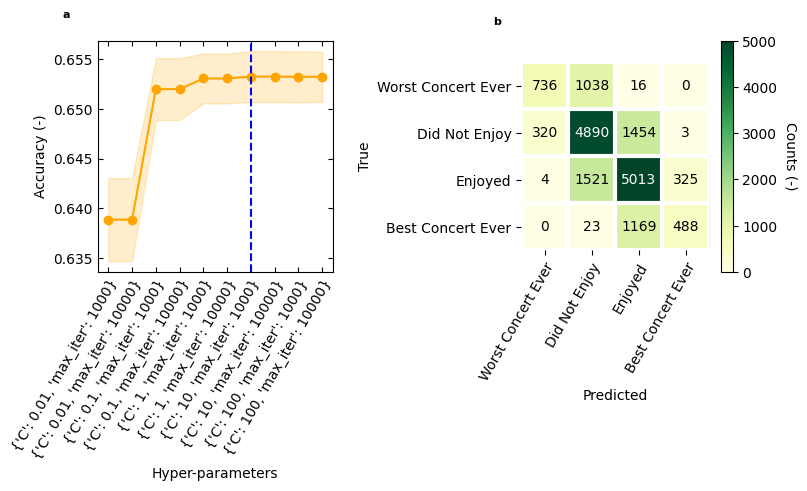

In [88]:
logistic_classifier_grid_search = joblib.load('/kaggle/working/logistic_classifier_acc0.65453.joblib')

y_pred = logistic_classifier_grid_search.predict(X_val)
target_names = list(target_transform.keys())

C = confusion_matrix(y_val, y_pred)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[8.5, 3], gridspec_kw={'hspace': 0.3, 'wspace': 0.8})

ax1.text(-0.15, 1.1, f'a', transform=ax1.transAxes, fontfamily='sans-serif',
                    fontsize=8, fontweight='bold')
ax2.text(-0.15, 1.2, f'b', transform=ax2.transAxes, fontfamily='sans-serif',
                    fontsize=8, fontweight='bold')

visualize_hyperparameter_tuning(logistic_classifier_grid_search, ax=ax1)
visualize_confusion_matrix(C, target_names, ax=ax2)

plt.show()


In [89]:
logistic_classifier_classification_report = classification_report( y_val, y_pred, target_names=target_names, output_dict=True )

print( pd.DataFrame.from_dict(logistic_classifier_classification_report).to_latex() )


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Worst Concert Ever &  Did Not Enjoy &      Enjoyed &  Best Concert Ever &  accuracy &     macro avg &  weighted avg \\
\midrule
precision &            0.694340 &       0.654443 &     0.655123 &           0.598039 &  0.654529 &      0.650486 &      0.653344 \\
recall    &            0.411173 &       0.733463 &     0.730439 &           0.290476 &  0.654529 &      0.541388 &      0.654529 \\
f1-score  &            0.516491 &       0.691704 &     0.690734 &           0.391026 &  0.654529 &      0.572489 &      0.643149 \\
support   &         1790.000000 &    6667.000000 &  6863.000000 &        1680.000000 &  0.654529 &  17000.000000 &  17000.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16767/2475157973.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print( pd.DataFrame.from_dict(logistic_classifier_classification_report).to_latex() )


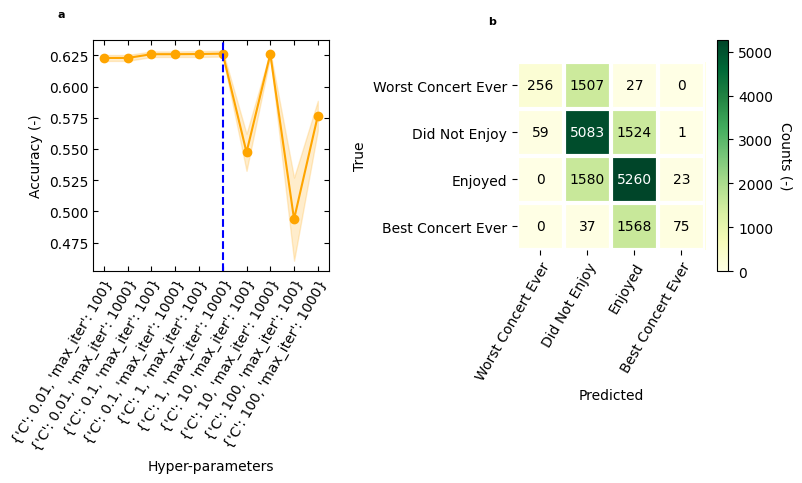

In [41]:
linear_svc_grid_search = joblib.load('/kaggle/working/linear_svc_acc0.62788.joblib')

y_pred = linear_svc_grid_search.predict(X_val)
target_names = list(target_transform.keys())

C = confusion_matrix(y_val, y_pred)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[8.5, 3], gridspec_kw={'hspace': 0.3, 'wspace': 0.8})

ax1.text(-0.15, 1.1, f'a', transform=ax1.transAxes, fontfamily='sans-serif',
                    fontsize=8, fontweight='bold')
ax2.text(-0.15, 1.2, f'b', transform=ax2.transAxes, fontfamily='sans-serif',
                    fontsize=8, fontweight='bold')

visualize_hyperparameter_tuning(linear_svc_grid_search, ax=ax1)
visualize_confusion_matrix(C, target_names, ax=ax2)

plt.show()


In [42]:
linear_svc_classification_report = classification_report( y_val, y_pred, target_names=target_names, output_dict=True )

print( pd.DataFrame.from_dict(linear_svc_classification_report).to_latex() )


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Worst Concert Ever &  Did Not Enjoy &      Enjoyed &  Best Concert Ever &  accuracy &     macro avg &  weighted avg \\
\midrule
precision &            0.812698 &       0.619349 &     0.627760 &           0.757576 &  0.627882 &      0.704346 &      0.656763 \\
recall    &            0.143017 &       0.762412 &     0.766429 &           0.044643 &  0.627882 &      0.429125 &      0.627882 \\
f1-score  &            0.243230 &       0.683475 &     0.690198 &           0.084317 &  0.627882 &      0.425305 &      0.580623 \\
support   &         1790.000000 &    6667.000000 &  6863.000000 &        1680.000000 &  0.627882 &  17000.000000 &  17000.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16767/3994902814.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print( pd.DataFrame.from_dict(linear_svc_classification_report).to_latex() )


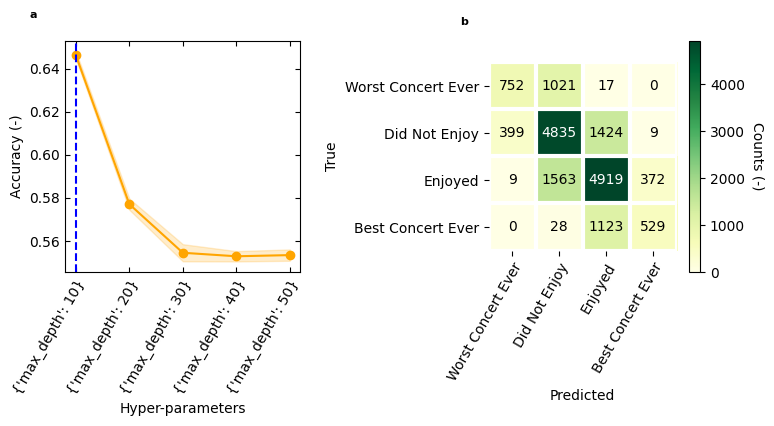

In [43]:
decision_tree_classifier_grid_search = joblib.load('/kaggle/working/decision_tree_classifier_acc0.64912.joblib')

y_pred = decision_tree_classifier_grid_search.predict(X_val)
target_names = list(target_transform.keys())

C = confusion_matrix(y_val, y_pred)


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[8.5, 3], gridspec_kw={'hspace': 0.3, 'wspace': 0.8})

ax1.text(-0.15, 1.1, f'a', transform=ax1.transAxes, fontfamily='sans-serif',
                    fontsize=8, fontweight='bold')
ax2.text(-0.15, 1.2, f'b', transform=ax2.transAxes, fontfamily='sans-serif',
                    fontsize=8, fontweight='bold')

visualize_hyperparameter_tuning(decision_tree_classifier_grid_search, ax=ax1)
visualize_confusion_matrix(C, target_names, ax=ax2)

plt.show()


In [44]:
decision_tree_classifier_classification_report = classification_report( y_val, y_pred, target_names=target_names, output_dict=True )

print( pd.DataFrame.from_dict(decision_tree_classifier_classification_report).to_latex() )

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Worst Concert Ever &  Did Not Enjoy &      Enjoyed &  Best Concert Ever &  accuracy &     macro avg &  weighted avg \\
\midrule
precision &            0.648276 &       0.649255 &     0.657357 &           0.581319 &  0.649118 &      0.634051 &      0.645709 \\
recall    &            0.420112 &       0.725214 &     0.716742 &           0.314881 &  0.649118 &      0.544237 &      0.649118 \\
f1-score  &            0.509831 &       0.685135 &     0.685766 &           0.408494 &  0.649118 &      0.572307 &      0.639593 \\
support   &         1790.000000 &    6667.000000 &  6863.000000 &        1680.000000 &  0.649118 &  17000.000000 &  17000.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16767/3224908093.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print( pd.DataFrame.from_dict(decision_tree_classifier_classification_report).to_latex() )


### Neural Networks

In [105]:
def visualize_learning_curve(train_stats: dict, ax1: matplotlib.pyplot.Axes):

    ax1.set_xlabel('Number of steps (-)')
    ax1.set_ylabel('Cross entropy loss (-)')
    ax1.plot(train_stats['train_steps'], train_stats['train_losses'], color='blue', alpha=0.2, label='Train loss')
    ax1.plot(train_stats['val_steps'], train_stats['val_losses'], color='orange', label='Val loss')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Accuracy (-)')  # we already handled the x-label with ax1
    ax2.plot(train_stats['val_steps'], train_stats['val_accuracies'], color='green', label='Val accuracy')
    ax2.axvline(train_stats['val_steps'][ np.argmax(train_stats['val_accuracies']) ], color='red', linestyle='--', label='Stop')

    ax1.legend(loc='lower left', framealpha=1, bbox_to_anchor=(0.1, 0), fontsize='small')
    ax2.legend(loc='lower right', framealpha=1, bbox_to_anchor=(0.9, 0), fontsize='small')

    ax1.tick_params(direction='in', top=True)
    ax2.tick_params(direction='in')


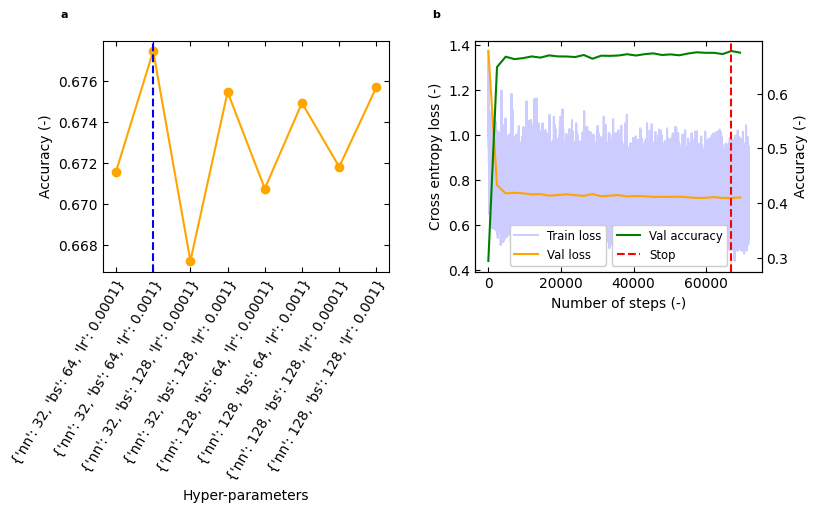

In [111]:

with open('/kaggle/working/neural_network_classifier_acc0.67747.pkl', 'rb') as handle:
    best_train_stats = pickle.load(handle)

neural_network_grid_search = joblib.load('/kaggle/working/neural_network_classifier_acc0.67747.joblib')

neural_network_grid_search.cv_results_['params'] = [
    {'nn': 32, 'bs': 64, 'lr': 0.0001}, 
    {'nn': 32, 'bs': 64, 'lr': 0.001}, 
    {'nn': 32, 'bs': 128, 'lr': 0.0001}, 
    {'nn': 32, 'bs': 128, 'lr': 0.001}, 
    {'nn': 128, 'bs': 64, 'lr': 0.0001}, 
    {'nn': 128, 'bs': 64, 'lr': 0.001}, 
    {'nn': 128, 'bs': 128, 'lr': 0.0001}, 
    {'nn': 128, 'bs': 128, 'lr': 0.001}
    ]
neural_network_grid_search.best_params_ = {'nn': 32, 'bs': 64, 'lr': 0.001}

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[8.5, 3], gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

ax1.text(-0.15, 1.1, f'a', transform=ax1.transAxes, fontfamily='sans-serif',
                    fontsize=8, fontweight='bold')
ax2.text(-0.15, 1.1, f'b', transform=ax2.transAxes, fontfamily='sans-serif',
                    fontsize=8, fontweight='bold')

visualize_hyperparameter_tuning(neural_network_grid_search, ax=ax1, std_test_score=False)
visualize_learning_curve(best_train_stats, ax1=ax2)

plt.show()


In [108]:
very_best_state = torch.load('/kaggle/working/neural_network_classifier_acc0.67747.pth')

NODE = neural_network_grid_search.best_params_['num_nodes']

model = FNNClassifier(in_features=X_train.shape[1], num_nodes=NODE, out_features=4)
model.load_state_dict( very_best_state )
model.eval()

outputs = model( torch.tensor(X_val, dtype=torch.float32) )
y_pred = outputs.argmax(axis=1).numpy()

neural_network_classification_report = classification_report( y_val, y_pred, target_names=target_names, output_dict=True )

print( pd.DataFrame.from_dict(neural_network_classification_report).to_latex() )


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Worst Concert Ever &  Did Not Enjoy &      Enjoyed &  Best Concert Ever &  accuracy &     macro avg &  weighted avg \\
\midrule
precision &            0.711470 &       0.675348 &     0.674227 &           0.613051 &  0.673235 &      0.668524 &      0.672543 \\
recall    &            0.443575 &       0.735113 &     0.740638 &           0.397024 &  0.673235 &      0.579088 &      0.673235 \\
f1-score  &            0.546456 &       0.703964 &     0.705874 &           0.481936 &  0.673235 &      0.609558 &      0.666209 \\
support   &         1790.000000 &    6667.000000 &  6863.000000 &        1680.000000 &  0.673235 &  17000.000000 &  17000.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_16767/1589285961.py:14: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print( pd.DataFrame.from_dict(neural_network_classification_report).to_latex() )
